In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
import subprocess

In [2]:
import os
import nibabel as nib
import numpy as np
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.segment.mask import median_otsu
from dipy.segment.mask import applymask
from dipy.segment.mask import bounding_box
from dipy.segment.mask import crop
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.imwarp import DiffeomorphicMap
from dipy.align.metrics import CCMetric

In [3]:
from dipy.viz import regtools
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

### Visualisation Function

In [11]:
def plot_chart(scan1, scan3, scan4, sagital=0, coronal=0, axial=0):
    plt.figure
    plt.figure(figsize=(8,8))
    plt.subplot(3,3,1).set_axis_off()
    plt.imshow(scan1[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 1 PET")
    plt.subplot(3,3,2).set_axis_off()
    plt.imshow(scan3[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 1 TRIO")
    plt.subplot(3,3,3).set_axis_off()
    plt.imshow(scan4[:, :, axial, 0].T, cmap='gray', origin='lower')
    plt.title("Scan 2 TRIO")
    plt.subplot(3,3,4).set_axis_off()
    plt.imshow(scan1[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,3,5).set_axis_off()
    plt.imshow(scan3[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,3,6).set_axis_off()
    plt.imshow(scan4[sagital, :, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,3,7).set_axis_off()
    plt.imshow(scan1[:, coronal, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,3,8).set_axis_off()
    plt.imshow(scan3[:, coronal, :, 0].T, cmap='gray', origin='lower')
    plt.subplot(3,3,9).set_axis_off()
    plt.imshow(scan4[:, coronal, :, 0].T, cmap='gray', origin='lower')

# Functions for performing affine transformation

In [5]:
def affine_registration(reference, reference_grid2world, scan, scan_grid2world):
    #get first b0 volumes for both scans
    reference_b0 = reference[:,:,:,0]
    scan_b0 = scan[:,:,:,0]
    
    #In this function we use multiple stages to register the 2 scans
    #providng previous results as initialisation to the next stage, 
    #the reason we do this is because registration is a non-convex 
    #problem thus it is important to initialise as close to the 
    #optiaml value as possible
    
    #Stage1: we obtain a very rough (and fast) registration by just aligning 
    #the centers of mass of the two images
    center_of_mass = transform_centers_of_mass(reference_b0, reference_grid2world, scan_b0, scan_grid2world)
    
    #create the similarity metric (Mutual Information) to be used:
    nbins = 32
    sampling_prop = None #use all voxels to perform registration
    metric = MutualInformationMetric(nbins, sampling_prop)
    
    #We use a multi-resolution stratergy to accelerate convergence and avoid
    #getting stuck at local optimas (below are the parameters)
    level_iters = [10000, 1000, 100]
    sigmas = [3.0, 1.0, 0.0] #parameters for gaussian kernel smoothing at each resolution
    factors = [4, 2, 1] #subsampling factor
    
    #optimisation algorithm used is L-BFGS-B
    affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
    
    #Stage2: Perform a basic translation transform
    transform = TranslationTransform3D()
    translation = affreg.optimize(reference_b0, scan_b0, transform, None, reference_grid2world, scan_grid2world, starting_affine=center_of_mass.affine)
    
    #Stage3 : optimize previous result with a rigid transform
    #(Includes translation, rotation)
    transform = RigidTransform3D()
    rigid = affreg.optimize(reference_b0, scan_b0, transform, None, reference_grid2world, scan_grid2world, starting_affine=translation.affine)
    
    #Stage4 : optimize previous result with a affine transform
    #(Includes translation, rotation, scale, shear)
    transform = AffineTransform3D()
    affine = affreg.optimize(reference_b0, scan_b0, transform, None, reference_grid2world, scan_grid2world, starting_affine=rigid.affine)
    
    #Stage 5 : Symmetric Diffeomorphic Registration
    metric = CCMetric(3)
    level_iters = [400, 200, 100]
    sdr = SymmetricDiffeomorphicRegistration(metric, level_iters)
    mapping = sdr.optimize(reference_b0, scan_b0, reference_grid2world, scan_grid2world, affine.affine)
    
    #Once this is completed we can perform the affine transformation on each 
    #volume of scan2
   
    for volume in range(0, scan.shape[3]):
        #note affine is an AffineMap object,
        #The transform method transforms the input image from co-domain to domain space
        #By default, the transformed image is sampled at a grid defined by the shape of the domain
        #The sampling is performed using linear interpolation (refer to comp vision lab on homographies)
        scan[:,:,:,volume] = mapping.transform(scan[:,:,:,volume])
        
    return scan
    

In [6]:
def compute_masks_crop(reference_scan, other_scan1, other_scan2):
    #Median_otsu is a segmnentation technique that is a hybridisation of median filtering and otsu thresholding
    #the combination (4,4) is shown to be the most robust
    _, reference_scan_mask = median_otsu(reference_scan, median_radius=4, numpass=4, autocrop=False, dilate=2)
    _, other_scan1_mask = median_otsu(other_scan1, median_radius=4, numpass=4, autocrop=False, dilate=2)
    _, other_scan2_mask = median_otsu(other_scan2, median_radius=4, numpass=4, autocrop=False, dilate=2)
    
    #Get the intersection of the masks
    mask_union = np.logical_and(reference_scan_mask, np.logical_and(other_scan1_mask, other_scan2_mask))
    
    #Apply the combined mask to the scans
    reference_scan_brain = applymask(reference_scan, mask_union)
    other_scan1_brain = applymask(other_scan1, mask_union)
    other_scan2_brain = applymask(other_scan2, mask_union)
    
    #Crop the scans using the unioned mask
    (mins, maxs) = bounding_box(mask_union)
    reference_scan_brain = crop(reference_scan_brain, mins, maxs)
    other_scan1_brain = crop(other_scan1_brain, mins, maxs)
    other_scan2_brain = crop(other_scan2_brain, mins, maxs)
    
    return (reference_scan_brain, other_scan1_brain, other_scan2_brain)  

In [7]:
def compute_masks_crop_bet(reference_scan, other_scan1, other_scan2, ref_data_path, other_data_path, subject, scan):
    # Use bet for generating brain masks for each of the scans

    # Get the mask of the reference scan 
    os.chdir(ref_data_path + "/Subj" + str(subject) + "Scan" +str(scan))
    subprocess.call(["bet", "NODDI_3Shells.nii", "Brain_temp", "-m", "-n", "-R", "-f", "0.2", "-t"])
    reference_scan_mask = nib.load("Brain_temp_mask.nii.gz")
    reference_scan_mask = reference_scan_mask.get_data()
    # Delete the created files
    os.remove('Brain_temp.nii.gz')
    os.remove('Brain_temp_mask.nii.gz')

    # Similarly get the masks of the other scans
    os.chdir(other_data_path + "/Subj" + str(subject) + "Scan1")
    subprocess.call(["bet", "Full_Registered_Scan" + str(scan) + ".nii.gz", "Brain_temp", "-m", "-n", "-R", "-f", "0.2", "-t"])
    other_scan1_mask = nib.load("Brain_temp_mask.nii.gz")
    other_scan1_mask = other_scan1_mask.get_data()
    os.remove('Brain_temp.nii.gz')
    os.remove('Brain_temp_mask.nii.gz')
        
    os.chdir(other_data_path + "/Subj" + str(subject) + "Scan2")
    subprocess.call(["bet", "Full_Registered_Scan" + str(scan) + ".nii.gz", "Brain_temp", "-m", "-n", "-R", "-f", "0.2", "-t"])
    other_scan2_mask = nib.load("Brain_temp_mask.nii.gz")
    other_scan2_mask = other_scan2_mask.get_data()
    os.remove('Brain_temp.nii.gz')
    os.remove('Brain_temp_mask.nii.gz')
    
    #Get the intersection of the masks
    mask_union = np.logical_and(reference_scan_mask, np.logical_and(other_scan1_mask, other_scan2_mask))
    
    #Apply the combined mask to the scans
    reference_scan_brain = applymask(reference_scan, mask_union)
    other_scan1_brain = applymask(other_scan1, mask_union)
    other_scan2_brain = applymask(other_scan2, mask_union)
    
    #Crop the scans using the unioned mask
    (mins, maxs) = bounding_box(mask_union)
    reference_scan_brain = crop(reference_scan_brain, mins, maxs)
    other_scan1_brain = crop(other_scan1_brain, mins, maxs)
    other_scan2_brain = crop(other_scan2_brain, mins, maxs)
    
    return (reference_scan_brain, other_scan1_brain, other_scan2_brain)  


In [8]:
def perform_registration(dataset_path_petmr, dataset_path_trio, reference):
    # Iterate through the subjects in the directory
    
    if reference == "PETMR":
        ref_data_path = dataset_path_petmr
        other_data_path = dataset_path_trio
    else:
        ref_data_path = dataset_path_trio
        other_data_path = dataset_path_petmr
    
    subjects = [1,2,3,4,5,6,7,8,9,10]
    scans = [1,2]
    for subject in subjects:
        for scan in scans:
            
            print ("Processing Subject %s, Using Scan %s (%s) as the reference scan" % (str(subject), str(scan), reference))
            # Load the reference scan and the 2 corresponding scans from the other scanner
                
            reference_scan = nib.load(ref_data_path + "/Subj" + str(subject) + "Scan" +str(scan) + "/NODDI_3Shells.nii.gz")
            other_scan1 = nib.load(other_data_path + "/Subj" + str(subject) + "Scan1" + "/NODDI_3Shells.nii.gz")
            other_scan2 = nib.load(other_data_path + "/Subj" + str(subject) + "Scan2" + "/NODDI_3Shells.nii.gz")
            
            # Convert the images to dipy format
            reference_scan_data = reference_scan.get_data()
            other_scan1_data = other_scan1.get_data()
            other_scan2_data = other_scan2.get_data()
            
            # Get the grid2world matrices for each scan
            reference_scan_grid2world = reference_scan.affine
            other_scan1_grid2world = other_scan1.affine
            other_scan2_grid2world = other_scan2.affine
            
            # Perform registration using the 'reference_scan' as the static/reference scan
            # i.e we apply spatial transformations to all other scans to achive spatial correspondance with the reference_scan
            # by doing so we indirectly achive spatial correspondace between all scans
            print ("Performing Registration for: Scan 1")
            other_scan1_transformed = affine_registration(reference_scan_data, reference_scan_grid2world, other_scan1_data, other_scan1_grid2world)
            print ("Performing Registration for: Scan 2")
            other_scan2_transformed = affine_registration(reference_scan_data, reference_scan_grid2world, other_scan2_data, other_scan2_grid2world)
            print ("---Registration Completed---")

            # Create images from the data
            other_scan1_img = nib.Nifti1Image(other_scan1_transformed.astype(np.float32), reference_scan.affine)
            other_scan2_img = nib.Nifti1Image(other_scan2_transformed.astype(np.float32), reference_scan.affine)
            
            nib.save(other_scan1_img, other_data_path + "/Subj" + str(subject) + "Scan1" + "/Full_Registered_Scan" + str(scan) + ".nii.gz")
            nib.save(other_scan2_img, other_data_path + "/Subj" + str(subject) + "Scan2" + "/Full_Registered_Scan" + str(scan) + ".nii.gz")    

            # Compute brain masks for each scan - Use FSL BET for this
            print ("Computing brain masks")
            (reference_brain, other_brain1, other_brain2) = \
                compute_masks_crop_bet(reference_scan_data, other_scan1_transformed, other_scan2_transformed, ref_data_path, other_data_path, subject, scan)

            # Save the new masked/cropped scans
            print ("Saving cropped masks")  
            
            # Create images from the cropped data
            reference_brain_img = nib.Nifti1Image(reference_brain.astype(np.float32), reference_scan.affine)
            other_brain1_img = nib.Nifti1Image(other_brain1.astype(np.float32), reference_scan.affine)
            other_brain2_img = nib.Nifti1Image(other_brain2.astype(np.float32), reference_scan.affine)
            
            # Store the images -- These are cropped
            nib.save(reference_brain_img, ref_data_path + "/Subj" + str(subject) + "Scan" + str(scan) + "/Brain_Extracted" + ".nii.gz")
            nib.save(other_brain1_img, other_data_path + "/Subj" + str(subject) + "Scan1" + "/Brain_Extracted_Scan" + str(scan) + ".nii.gz")
            nib.save(other_brain2_img, other_data_path + "/Subj" + str(subject) + "Scan2" + "/Brain_Extracted_Scan" + str(scan) + ".nii.gz")

            print ("---Iteration Complete---")

----------------------------------------------------------------------------------------------------------
---

----------------------------------------------------------------------------------------------------------
---

# With automated functions

In [13]:
dataset_path_trio = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data' 
dataset_path_petmr = '/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data'
perform_registration(dataset_path_petmr, dataset_path_trio, reference="TRIO")

Processing Subject 1, Using Scan 1 (TRIO) as the reference scan
Performing Registration for: Scan 1
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0
Performing Registration for: Scan 2
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
C

## Check results

In [10]:
os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/PETMR_data/Subj1Scan1/')
imgScan1 = nib.load("Brain_Extracted.nii.gz")
petmr_scan1 = imgScan1.get_data()

os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj1Scan1/')
imgScan3 = nib.load("Brain_Extracted_Scan1.nii.gz")
trio_scan1 = imgScan3.get_data()

os.chdir('/Volumes/Seagate Backup Plus Drive/Project/Dataset/TRIO_data/Subj1Scan2/')
imgScan4 = nib.load("Brain_Extracted_Scan1.nii.gz")
trio_scan2 = imgScan4.get_data()

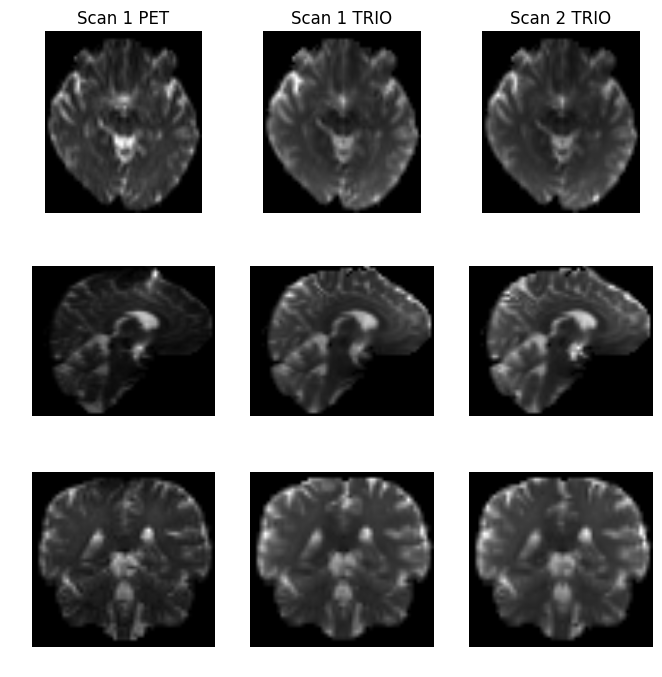

In [12]:
plot_chart(petmr_scan1, trio_scan1, trio_scan2, 25, 25, 25)

In [2]:
cd Model_Params_AWS/

/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS
